In [168]:
import cv2
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle
import skimage.feature

In [112]:
def get_search_windows(img):
    y_horizon = 440
    y_bonnet = 650
    
    window_dim_at_horizon = 64
    window_bottom_at_horizon = y_horizon + window_dim_at_horizon / 2
    
    window_center_at_bonnet = 480
    window_dim_at_bonnet = (y_bonnet - window_center_at_bonnet) * 2
    
    num_window_centers = 4
    
    window_bottoms = np.linspace(window_bottom_at_horizon, y_bonnet, num_window_centers, dtype=np.int16)
    window_dims = (window_dim_at_horizon +
                   (window_dim_at_bonnet - window_dim_at_horizon) /
                   (y_bonnet - window_bottom_at_horizon) * (window_bottoms - window_bottom_at_horizon)
                  ).astype(np.int16)
    
    window_x_overlap = 0.6
    
    windows = []
    for btm, dim in zip(window_bottoms, window_dims):
        top = btm - dim
        
        lefts = np.arange(0, img.shape[1], int(dim * (1 - window_x_overlap)))
        
        for left in lefts:
            right = left + dim
            windows.append(((left, top), (right, btm)))
    return windows
    
def visualize_search_windows(img, windows):
#     for corner0, corner1 in windows:
#         cv2.rectangle(img, corner0, corner1, (255,0,255), 2)

    def color_range(num):
        colors = np.vstack((
            np.linspace(0, 255, num),
            np.ones(num) * 255,
            np.ones(num) * 255)).astype(np.uint8).T
        colors = np.array([colors])
        colors = cv2.cvtColor(colors, cv2.COLOR_HSV2BGR)[0]
        return colors
    
    colors = color_range(len(windows)).astype(np.float)
    
    for (corner0, corner1), color in zip(windows, colors):
#         cv2.circle(img, corner0, 5, color, 3)

        cv2.line(img, corner0, corner1, color, 3)

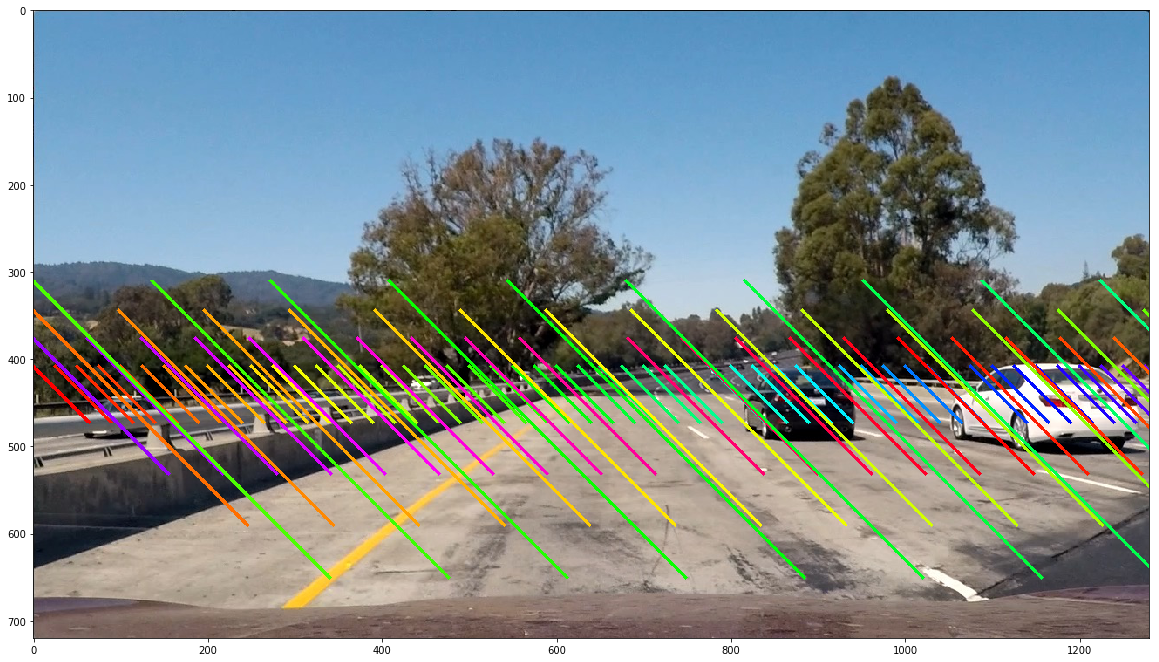

In [135]:
img = cv2.imread('test_images/test1.jpg')
windows = get_search_windows(img)
visualize_search_windows(img, windows)
plt.figure(figsize=(20, 20))
plt.imshow(img[:,:,::-1])

### visualization helpers

In [199]:
def color_spectrum(num):
    colors = np.vstack((
        np.linspace(0, 255, num + 1)[:-1],
        np.ones(num) * 255,
        np.ones(num) * 255
    )).astype(np.uint8).T # `num` by 3 HSV colors
    colors = np.array([colors]) # 1 height by `num` width by 3 colors
    colors = cv2.cvtColor(colors, cv2.COLOR_HSV2RGB)
    colors = colors[0] # `num` by 3 colors
    return colors.astype(np.float) # cv2 color input needs to be float

### constrained areas in which to run hog

In [200]:
def get_hog_constraints():
#     return [
#         (440, 8 * 6),
#         (460, 8 * 8),
#         (480, 8 * 10),
#         (480, 8 * 20)
#     ]
#     return [
#         (440, 90),
#         (450, 130),
#         (460, 150),
#         (500, 400)
#     ]
    return [
        (440, 90),
        (440, 130),
        (440, 150),
        (440, 400)
    ]

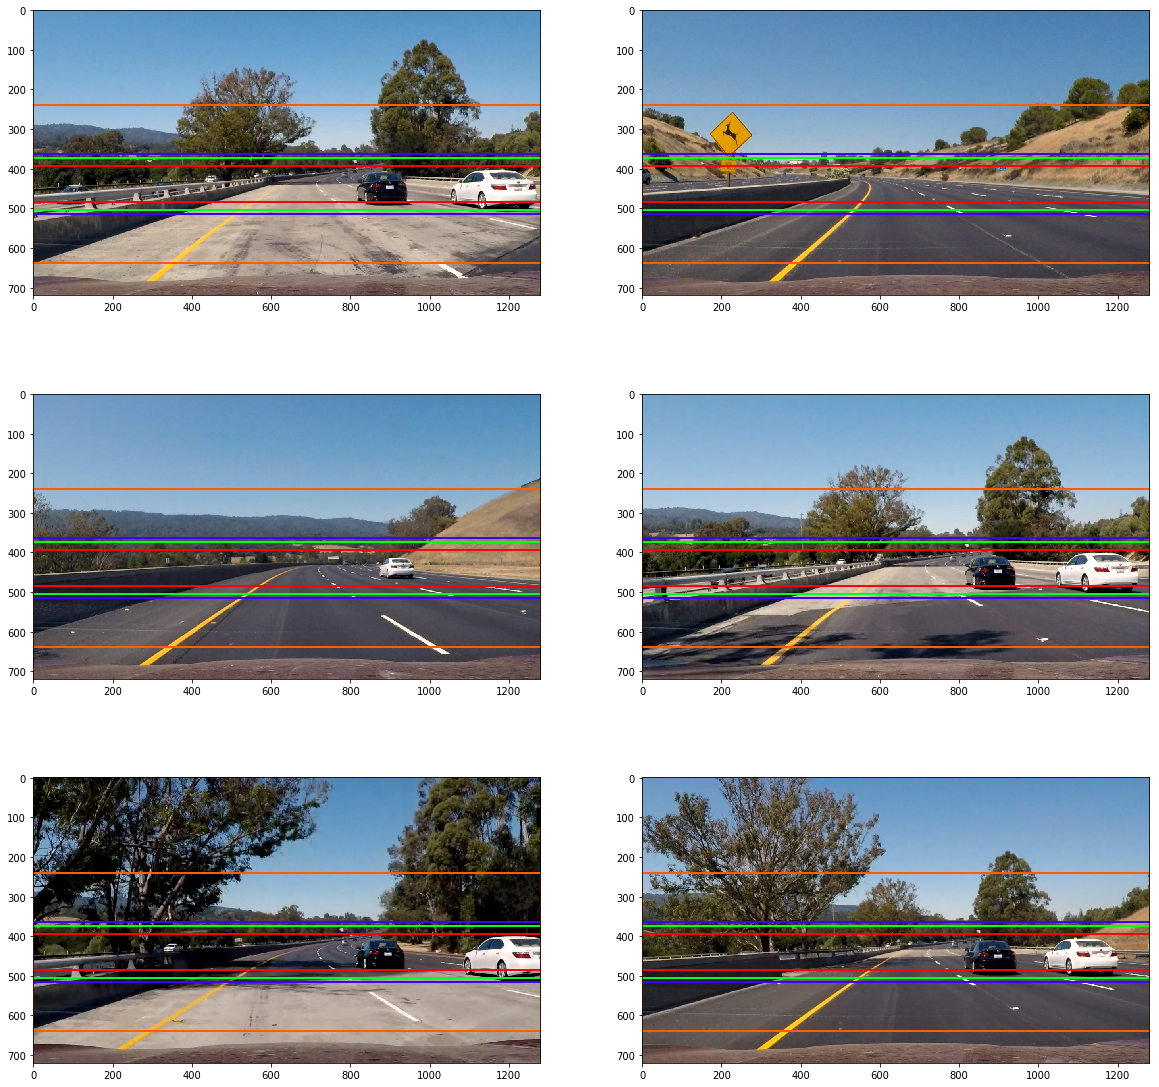

In [201]:
def visualize_hog_constraints_test_images():
    def do_visualize(img):
        hog_constraints = get_hog_constraints()

        colors = color_spectrum(len(hog_constraints))

        for (hog_y_center, hog_h), color in zip(hog_constraints, colors):
            hog_y_top = int(hog_y_center - hog_h / 2)
            hog_y_btm = int(hog_y_center + hog_h / 2)
            cv2.rectangle(img, (0, hog_y_top), (img.shape[1] - 1, hog_y_btm), color, 3)
    
    img_paths = glob.glob('test_images/*')
    fig, axes = plt.subplots(ncols=2, nrows=math.ceil(len(img_paths) / 2), figsize=(20, 20))
    axes = axes.flatten()
    
    for img_path, ax in zip(img_paths, axes):
        img_bgr = cv2.imread(img_path)
        img_rgb = np.array(img_bgr[:,:,::-1])
        do_visualize(img_rgb)
        ax.imshow(img_rgb)

visualize_hog_constraints_test_images()

### predict

In [138]:
with open('working_dir/training_result.p', 'rb') as f:
    training_result = pickle.load(f)

In [142]:
clf = list(training_result.keys())[0] # TODO fix the pickle

In [143]:
clf

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x125ac1518>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x132816240>, 'class_weight': ['balanced', None], 'kernel': ['rbf']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

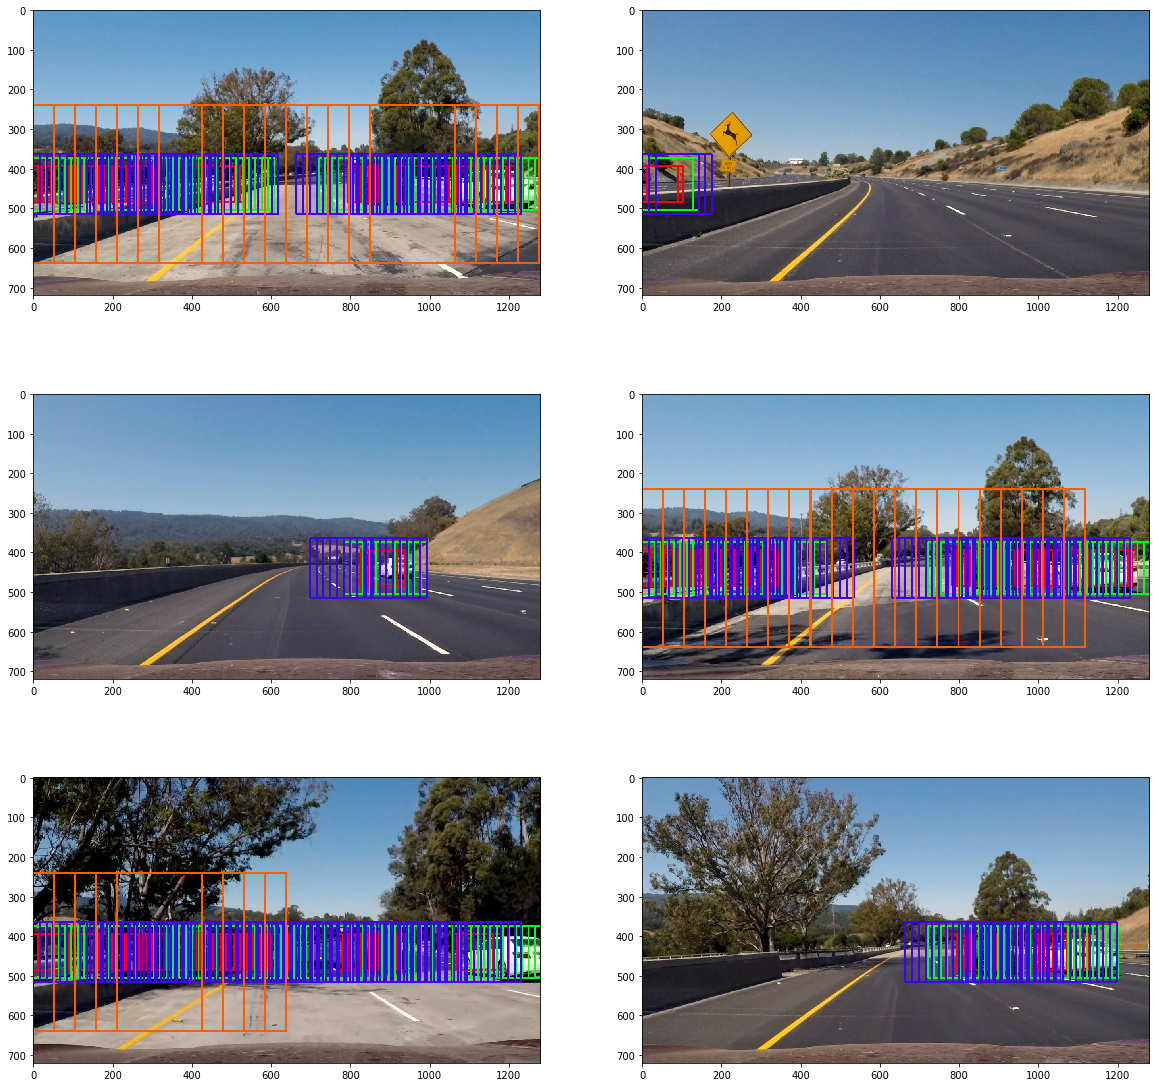

In [213]:
def image_to_hog_features(img_rgb):
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    img_lch = img_hls[:,:,1]
    img_sch = img_hls[:,:,2]
    
    hog_lch, hog_sch = [
        skimage.feature.hog(
            ch,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            transform_sqrt=True,
            visualise=False,
            feature_vector=False, # Do NOT flatten features.
            block_norm='L2-Hys')
        for ch in [img_lch, img_sch]]
    
    return (hog_lch, hog_sch)

# def get_search_windows():
#     hog_top = 440 - 8 * 26
#     hog_btm = 440 + 8 * 26
    
def search(img_rgb):
    hog_constraints = get_hog_constraints()

    colors = color_spectrum(len(hog_constraints))
    
    for (hog_y_center, hog_h), color in zip(hog_constraints, colors):
        hog_top = int(hog_y_center - hog_h / 2)
        hog_btm = int(hog_y_center + hog_h / 2)
        
        # Force w to be a mult of 64, s.t. the right-most window touches the right edge.
        # This skews a bit horizontally, but with the original w of 1280, it shouldn't matter too much.
        hog_input_w = round(img_rgb.shape[1] / (hog_btm - hog_top)) * 64
        hog_input_img = cv2.resize(img_rgb[hog_top:hog_btm, :, :], (hog_input_w, 64))
        
        hog_lch, hog_sch = image_to_hog_features(hog_input_img)
        
        num_blocks_per_window = hog_lch.shape[0]
        num_windows = hog_lch.shape[1] - num_blocks_per_window + 1
        num_cells_x = hog_lch.shape[1] + hog_lch.shape[3] - 1
        cell_w = int(img_rgb.shape[1] / num_cells_x)
        window_w = int(img_rgb.shape[1] / num_cells_x * 8)
        
        for block_ind_x in range(num_windows):
            window_features = np.concatenate((
                hog_lch[:, block_ind_x : block_ind_x + num_blocks_per_window].flatten(),
                hog_sch[:, block_ind_x : block_ind_x + num_blocks_per_window].flatten()
            ))
            predicted = clf.predict([window_features])
            
            if predicted == 1:
                x0 = cell_w * block_ind_x
                x1 = x0 + window_w
                cv2.rectangle(img_rgb, (x0, hog_top), (x1, hog_btm), color, 3)

def search_test_images():
    img_paths = glob.glob('test_images/*')
    fig, axes = plt.subplots(ncols=2, nrows=math.ceil(len(img_paths) / 2), figsize=(20, 20))
    axes = axes.flatten()
    
    for img_path, ax in zip(img_paths, axes):
        img_bgr = cv2.imread(img_path)
        img_rgb = np.array(img_bgr[:,:,::-1])
        search(img_rgb)
        ax.imshow(img_rgb)

search_test_images()

In [ ]:
def search_in_image(img_hls):
    